In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import clear_output

import torch.nn as nn
import torch.nn.utils.prune as prune
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
n = 2*10**4    # this includs training data, validationm data and testing data. 
d = 30
sigma = 0.5

# define regression function
def reg_func(x):
    y = np.exp(x[1] + x[2]) + 4 * x[3]**2    # X unif[-1,1], Bayes risk approx 1.448286 + sigma^2
    return y

# generate X and Y
X = np.random.uniform(-1 , 1, (n, d))
epsilon = np.random.normal(0, sigma, n)
Y = np.zeros(n)
for i in range(n):
    Y[i] = reg_func(X[i,:]) + epsilon[i]

# generate Omega, which has iid Ber(0.5) coordinates, independent of X
Omega = np.random.binomial(1, 0.5, (n, d))
Z_ZI = X * Omega

In [3]:
# split data into 50% training data, 25% validation data, 25% testing data
Z_ZI_train = Z_ZI[0:int(n/2), :]
Z_ZI_val = Z_ZI[int(n/2):int(3*n/4), :]
Z_ZI_test = Z_ZI[int(3*n/4):n, :]
Omega_train = Omega[0:int(n/2), :]
Omega_val = Omega[int(n/2):int(3*n/4), :]
Omega_test = Omega[int(3*n/4):n, :]
Y_train = Y[0:int(n/2)]
Y_val = Y[int(n/2):int(3*n/4)]
Y_test = Y[int(3*n/4):n]

# convert data into tensors
Z_ZI_train = torch.tensor(Z_ZI_train, dtype=torch.float32)
Z_ZI_val = torch.tensor(Z_ZI_val, dtype=torch.float32)
Z_ZI_test = torch.tensor(Z_ZI_test, dtype=torch.float32)
Omega_train = torch.tensor(Omega_train, dtype=torch.float32)
Omega_val = torch.tensor(Omega_val, dtype=torch.float32)
Omega_test = torch.tensor(Omega_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train.reshape(-1, 1), dtype=torch.float32)
Y_val = torch.tensor(Y_val.reshape(-1, 1), dtype=torch.float32)
Y_test = torch.tensor(Y_test.reshape(-1, 1), dtype=torch.float32)

In [4]:
### Pattern Embedding Neural Network (PENN)
class PENN(nn.Module):
    def __init__(self):
        super().__init__()
        embedding_dim = 6
        
        # Construct the neural network f2
        self.f2 = nn.Sequential(
            nn.Linear(d, 80),  
            nn.ReLU(),
            nn.Linear(80, 80),  
            nn.ReLU(),
        )

        # Construct the neural network f3, i.e. the embedding function
        self.f3 = nn.Sequential(
            nn.Linear(d, 30),  
            nn.ReLU(),
            nn.Linear(30, 30),  
            nn.ReLU(),
            nn.Linear(30, embedding_dim)
        )

        
        # Construct the neural network f1
        self.f1 = nn.Sequential(
            nn.Linear(80 + embedding_dim, 80),
            nn.ReLU(),
            nn.Linear(80, 80),
            nn.ReLU(),
            nn.Linear(80, 1)  
        )
    
    # Combine f1, f2 and f3 to construct the Pattern Embedding Neural Network (PENN)
    def forward(self, z, omega):
        # compute the output of f2 and f3
        f2_output = self.f2(z)
        f3_output = self.f3(omega)
        
        # Concatenate the output of f2 and f3
        combined_features = torch.cat((f2_output, f3_output), dim=1)
        
        # Apply the combined network
        final_output = self.f1(combined_features)
        
        return final_output

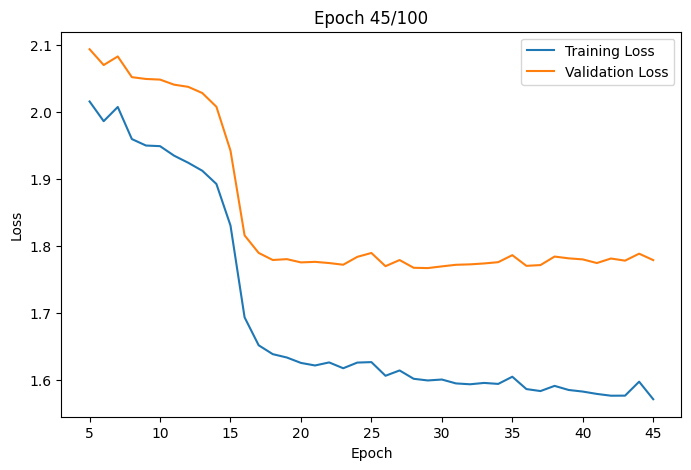

test_loss: 0.1295149326324463


In [7]:
lr = 0.001
l1_lambda = 0.001 
epochs = 100
patience = 20
threshold = 0.001

model_PENN = PENN()
PENN_train_data = TensorDataset(Z_ZI_train, Omega_train, Y_train)
PENN_train_loader = DataLoader(dataset = PENN_train_data, batch_size=200, shuffle=True)

optimizer = optim.Adam(model_PENN.parameters(), lr=lr)
loss_fn = nn.MSELoss()

train_losses = []
val_losses = []

for epoch in range(epochs):

    model_PENN.train()
    for z_batch, omega_batch, y_batch in PENN_train_loader:
        optimizer.zero_grad()
        pred = model_PENN(z_batch, omega_batch)
        loss = loss_fn(pred, y_batch)

        # L1 penalty
        l1_penalty = 0
        for param in model_PENN.parameters():
            l1_penalty += torch.sum(torch.abs(param))
        loss += l1_lambda * l1_penalty

        loss.backward()
        optimizer.step()
        
    if epoch >= 4:
        model_PENN.eval()
        with torch.no_grad():
            train_losses.append(loss_fn(model_PENN(Z_ZI_train, Omega_train), Y_train))
            val_losses.append(loss_fn(model_PENN(Z_ZI_val, Omega_val), Y_val))

        # Live plotting
        clear_output(wait=True)  # Clear previous output (Jupyter only)
        plt.figure(figsize=(8, 5))
        plt.plot(range(5,epoch+2), train_losses, label='Training Loss')
        plt.plot(range(5,epoch+2), val_losses, label='Validation Loss')
        plt.title(f'Epoch {epoch+1}/{epochs}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Early stopping
        min_index = val_losses.index(min(val_losses))
        if epoch - min_index >= patience:
            break
        

### set every parameter below threshold to zero
    with torch.no_grad():
        for param in model_PENN.parameters():
            param.data[param.abs() <= threshold] = 0   

# print excess risk
print(f'test_loss: {loss_fn(model_PENN(Z_ZI_test, Omega_test), Y_test) - 1.448 - sigma**2}')